### Combined Image processesing, classification, and region drawing

In [548]:
# Image and Data Processing
import datetime
import os
import numpy as np
import imagecodecs
import tifffile as tif
import scipy as sci
# Running Models
import tensorflow as tf
from tensorflow import keras
# Loading Models
import pickle
# Figures
import matplotlib.pyplot as plt

### Parameters

In [559]:
### For demo-ing: Do not use STO. The provided file does not have any defects. To demo STO models, use other STO images. ###

### Put Material below 'CdTe' or 'STO'. Match Material structure to one of these parameters based on simularity 
Material = 'CdTe'
### put input/image file here
fileName = 'CdTe_Training_Image.tif' 
### Output folder name (no '/')
folderName = 'testing'


### Hyperparameters
stride = 4 # Lower = better resolution, worse performance. Model only works well between 1 and 64 inclusively and divisible by 2, gives decent performance at 16. Alters featureThreshold characteristics.
featureThreshold = 100 # Recommended 2 or more. Reduces misclassification. Larger numbers work well with higher stride. Alternatively:
useCalculatedThreshold = True #
detectDefect = -1 # Uses model corresponding to defect at given index. -1 for all. See Dict below for specifics
## STO: 0: Bulk, 1: Small Interstitial, 2: Replacement, 3: Vacancy 

### System Vars

In [ ]:
calculateMask = True 
classification_window = [64, 64]
modelFolder = 'TrainedModels/'
label_encoding = {
    # CdTe
    'Bulk': [1,0,0,0,0,0,0,0],
    'LC': [0,1,0,0,0,0,0,0],
    'SF1': [0,0,1,0,0,0,0,0],
    'Vacancy': [0,0,0,1,0,0,0,0],
    'interstitial': [0,0,0,0,1,0,0,0],
    'SF2': [0,0,0,0,0,1,0,0],
    'Twin': [0,0,0,0,0,0,1,0],  
    # STO features
    'Extra': [0,0,0,0,1,0,0,0], # same as interstitial
    'IExtra': [0,0,0,0,0,0,0,1],  # new
    'Mis': [0,0,0,1,0,0,0,0],  # same as vacancy
}
label_decoding = { # no replacement in CdTe, so no model
    0: 'Bulk',
    1: 'LC',
    2: 'SF1',
    3: 'Vacancy',
    4: 'Interstitial',
    5: 'SF2',
    6: 'Twin',
    7: 'Replacement',
}

### Load Models

In [ ]:
# Maintaines index order of label decoding
models = []
CdTe_Model_Files = ['_Bulk_s.bin', '_LC_s.bin', '_SF1_s.bin', '_Vac_s.bin', '_Int_s.bin', '_SF2_s.bin', '_Twin_s.bin']
STO_Model_Files = ['_Bulk_s.bin', '_Int_s.bin', '_Rep_s.bin', '_Vac_s.bin']
if Material == 'CdTe' and detectDefect == -1:
    for entry in CdTe_Model_Files:
        with open((modelFolder + Material + entry), 'rb') as file:
            models.append(pickle.load(file))
elif Material == 'CdTe':
    with open((modelFolder + Material + CdTe_Model_Files[detectDefect]), 'rb') as file:
        models.append(pickle.load(file))
if Material == 'STO' and detectDefect == -1:
    for entry in STO_Model_Files:
        with open((modelFolder + Material + entry), 'rb') as file:
            models.append(pickle.load(file))
elif Material == 'STO':
    with open((modelFolder + Material + STO_Model_Files[detectDefect]), 'rb') as file:
        models.append(pickle.load(file))
models[0].summary()

Model: "ImageClassificationCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 57, 57, 64)     │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 57, 57, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Norm_1 (BatchNormalization)     │ (None, 57, 57, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_2 (MaxPooling2D)        │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 28, 28, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Dense (Dense)            │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 882,533 (3.37 MB)

 Trainable params: 294,049 (1.12 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 588,100 (2.24 MB)

### Read in large image

In [521]:
input_image = []
if (fileName.find('.tif') != -1):
    input_image = tif.imread(fileName)
elif (fileName.find('.jpg')):
    input_image = plt.imread(fileName)

if (len(list(input_image.shape)) > 2):
    input_image = input_image[:,:,0]
input_image.shape

(768, 768)

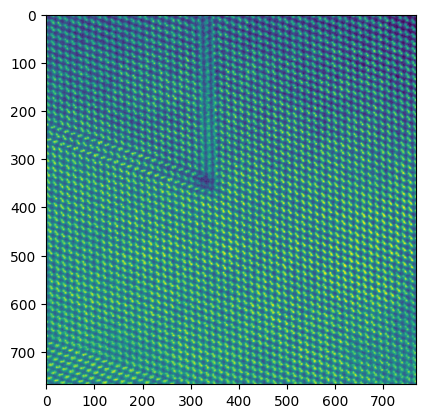

In [522]:
plt.imshow(input_image)

### Functions

In [523]:
def slice_image_and_process(image):
    samples = []
    row = 0
    while row + classification_window[0] < image.shape[0]+1:
        col = 0
        while col + classification_window[1] < image.shape[1]+1:
            image_window = image[row:row+classification_window[0],col:col+classification_window[1]]
            image_window = image_window / np.max(image_window)
            image_window =  sci.ndimage.gaussian_filter(image_window, 1)
            image_window = (np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(image_window)))))
            image_window = (image_window > 1) * image_window
            image_window = tf.convert_to_tensor(image_window, dtype=tf.float32)
            new_shape = list(np.shape(image_window))
            new_shape.append(1)
            image_window = tf.reshape(image_window, new_shape)
            samples.append(image_window)
            col += stride
        row += stride
    return np.array(samples)

In [524]:
def slice_image_source(image):
    samples = []
    row = 0
    while row + classification_window[0] < image.shape[0]:
        col = 0
        while col + classification_window[1] < image.shape[1]:
            samples.append(image[row:row+classification_window[0],col:col+classification_window[1]])
            col += stride
        row += stride
    return samples

In [525]:
def classify_with_loaded_model(images, model):
    feature_mask = model.predict(images)
    feature_mask = feature_mask > 0.5
    side_length = int(np.sqrt(len(feature_mask)))
    return np.array(feature_mask).reshape(side_length, side_length)

### Slice Image

In [526]:
simple_classification = []
image_slice = slice_image_and_process(input_image)


### Perform Classification

In [527]:
for model in models:
    simple_classification.append(classify_with_loaded_model(image_slice, model))

980/980 ━━━━━━━━━━━━━━━━━━━━ 139s 142ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 133s 136ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 132s 135ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 131s 133ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 131s 134ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 132s 134ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 134s 137ms/step


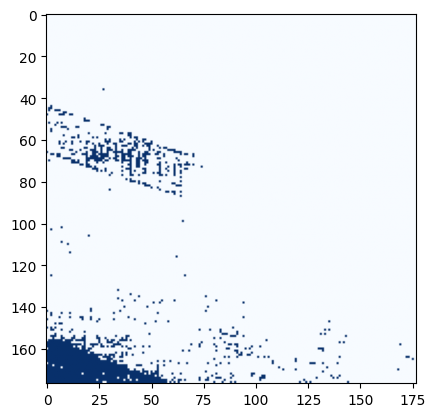

In [528]:
plt.imshow(simple_classification[-1], cmap='Blues')

### Create Classification Mask

In [529]:
if calculateMask:
    feature_masks = []
    for filter in simple_classification:
        mask = np.zeros(input_image.shape)
        for row in range(int((input_image.shape[0] - classification_window[0])/ stride)):
            for col in range(int((input_image.shape[1] - classification_window[1])  / stride)):
                mask[row * stride:row * stride + classification_window[0], col * stride:col * stride + classification_window[0]] += filter[row, col]
        
        feature_masks.append(mask)

In [543]:
scaled_masks = []
for mask in feature_masks:
    if useCalculatedThreshold:
        scaled_masks.append(mask * (mask > np.max(mask) * 0.5) * (mask > 16))
    else:
        scaled_masks.append(mask * (mask > featureThreshold))

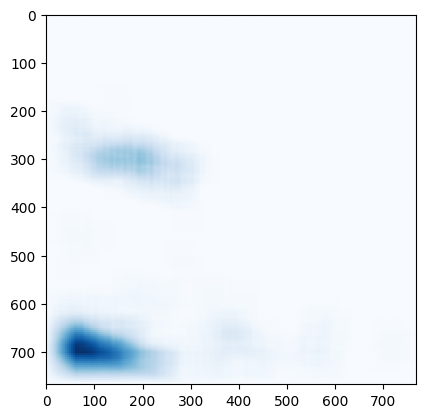

In [531]:
plt.imshow(feature_masks[-1], cmap='Blues')

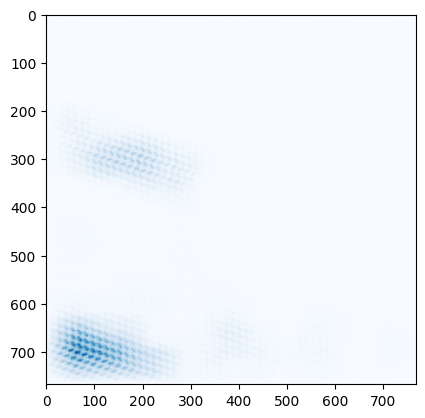

In [532]:
plt.imshow(input_image * feature_masks[-1] + input_image, cmap='Blues')

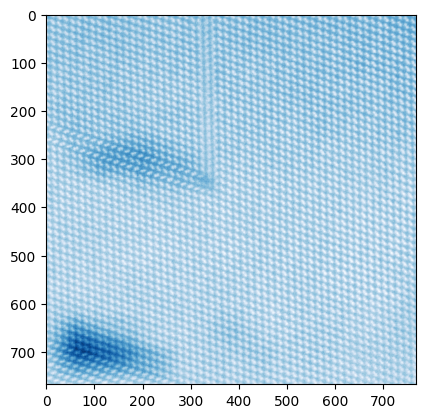

In [533]:
plt.imshow((feature_masks[-1]) - input_image, cmap='Blues')

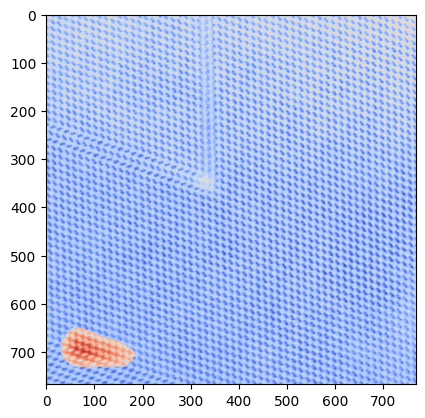

In [534]:
plt.imshow((scaled_masks[-1] - input_image), cmap='coolwarm')

In [535]:
#plt.imsave('ExampleLCDetection.png', (feature_masks[-1]) - input_image, cmap='grey')

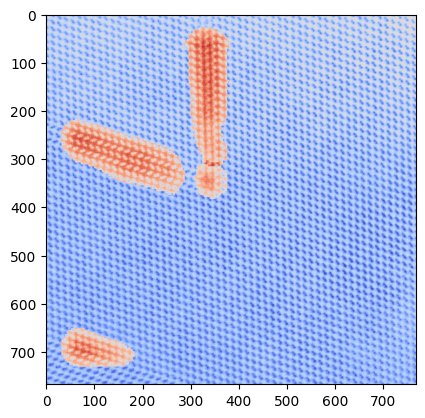

In [ ]:
plt.imshow((scaled_masks[1] + scaled_masks[2] + scaled_masks[5] + scaled_masks[6]) - input_image, cmap='coolwarm')

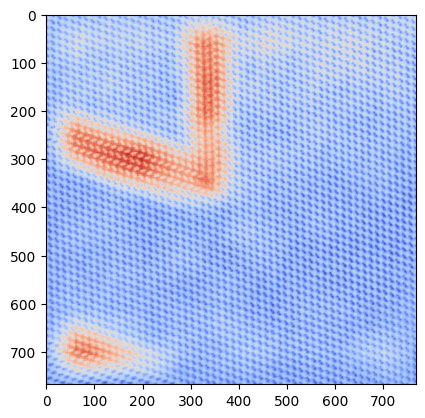

In [547]:
plt.imshow((feature_masks[1] + feature_masks[2] + feature_masks[5] + feature_masks[6]) - input_image, cmap='coolwarm')

### Save Output

In [560]:
def try_make_folder(nameBase, iter):
    if os.path.isdir(nameBase + ("%03d" % iter)):
        return try_make_folder(nameBase, iter+1)
    else:
        return nameBase + ("%03d" % iter)

In [569]:
if not os.path.isdir('Output'):
    os.mkdir('Output')

date = datetime.datetime.today().strftime('%Y-%m-%d')

outputFolder = 'Output/' + date + '-' + folderName + '_'
outputFolder = try_make_folder(outputFolder, 0) + '/'
os.mkdir(outputFolder)
tif.imwrite(outputFolder + 'Input.tif', input_image)
for index in range(len(feature_masks)):
    tif.imwrite(outputFolder + 'prob_' + label_decoding[index] + '.tif' , np.array(feature_masks[index], 'uint8' ))
for index in range(len(scaled_masks)):
    tif.imwrite(outputFolder + 'mask_' + label_decoding[index] + '.tif' , np.array(scaled_masks[index], 'uint8' ))